In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pymc3 as pm

import arviz as ar
import matplotlib.pyplot as pl
from matplotlib import rcParams
import seaborn as sb
%matplotlib inline

In [2]:
rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

### Methods

The dataset used in this study was generated from the NOMAD dataset. 6 Rrs bands were used at 6 wavelength corresponding to SeaWiFS spectral coverage; 412, 443, 490, 510, 555, 670 nm. The following data transformation steps were implemented:
* invalid data points were flagged and dropped
* for band ratio algorithms, relevant ratios were pre-computed
* for band ratio algorithms with max(Blue) formulation blue band used in the ratio was identified and flagged
* for PCA-based algorithms, principal components were computed for all bands.
* chlorophyll measurement method was identified and flagged
* all predictors were standardized

Before a principled statistical comparison of the different chlorophyll algorithms becomes possible, the different algorithms must be re-implemented using a Bayesian framework. The implementation follows the sequence below:

* Model coding using a probabilistic programming language (PPL)
* Prior predictive simulation 
* Model fitting using Hamiltonian Monte Carlo and the Nomad dataset
* Posterior predictive simulation to quantify predictive uncertainty
* Comparison of Model skill  on out-of-sample data using Information Criteria (IC) including Watanabe Akaike Information Criterion (WAIC) and/or Pareto Smoothed Importance Sampling Leave One Out Cross Validation (LOO).


1. Implementation of $OC_4$ 


    A. Without chlorophyll measurement error

In [24]:
X = df_log.log_mxBlu2Gr.values
y = df_log.log_chlor_a.values
X_poly = np.c_[X, np.power(X, 2), np.power(X, 3), np.power(X, 4)]

In [25]:
X_poly.shape

(1016, 4)

In [32]:
with pm.Model() as m_oc4:
    α = pm.Normal('α', 0, 1)
    β = pm.Normal('β', 0, 1, shape=X_poly.shape[1])
    σ = pm.Exponential('σ', 1)
    μ =  α + pm.math.dot(X_poly, β)
    log_chl = pm.Normal('log_chl', mu=μ, sd=σ, observed=y)

In [33]:
render = pm.model_to_graphviz(m_oc4)

In [34]:
render.render('m_oc4', directory='./figJar', format='png');

<img src='./figJar/m_oc4.png?:0' />

In [37]:
m_oc4_priors = pm.sample_prior_predictive(model=m_oc4,
                                         vars=['α', 'β', 'σ', 'log_chl'])

In [38]:
α_prior = m_oc4_priors['α']
β_prior = m_oc4_priors['β']
σ_prior = m_oc4_priors['σ']
log_chl_prior = m_oc4_priors['log_chl']

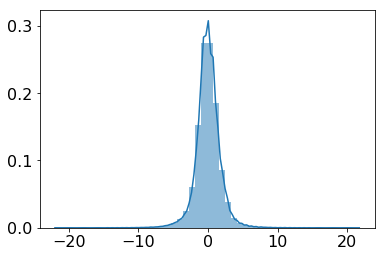

In [42]:
f, ax = pl.subplots(figsize=(6, 4))
sb.distplot(log_chl_prior.flatten(),
            hist_kws={'alpha': 0.5})
sb.distplot(log_chl_prior.flatten(), )

In [45]:
with m_oc4:
    trace_oc4 = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:19<00:00, 310.80draws/s]


In [49]:
m_oc4_posteriors = {k: trace_oc4.get_values(k) for k in ['α', 'β', 'σ']}

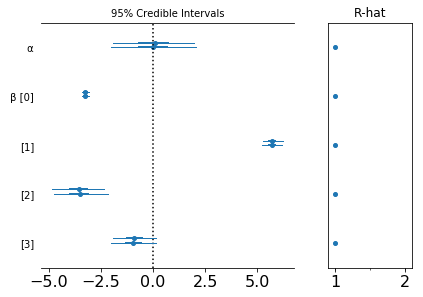

In [47]:
pm.forestplot(trace_oc4, varnames=['α', 'β']);

    B. With chlorophyll measurement error

2. Implementation of $OC_x$ with $CI$ split


    A. Without chlorophyll measurement error

In [ ]:
with pm.Model() as m_oci:
    \alpha

    B. With chlorophyll measurement error

3. Simple band ratio

    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error

4. Multivariate Linear Regression


    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error

5. Multivariate Linear Regression with Prior Transformation of Principal Components of Reflectance

    A. Without chlorophyll measurement error

    B. With chlorophyll measurement error